We call a code linear if it forms a subspace of the Hamming space, regarded as a vector space over the field $F$ of $2$ elements. The weight $w(x)$ of a vector $x$ is the number of non-zero components, that is, the Hamming distance $d(x, 0)$. The minimum distance of a linear code is just the minimum non-zero weight. The rank $k$ of a linear code is the dimension of the code as a subspace, and the size of a linear code is $r = 2k$.


In [18]:
import random
import math
import itertools
import matplotlib.pyplot as plt
import numpy as np

def xor_vectors(vec1, vec2):
    '''
    Performs bitwise XOR on two binary strings of the same length.
    '''
    return "".join(['1' if c1 != c2 else '0' for c1, c2 in zip(vec1, vec2)])

class LinearCode:
    '''
    Represents a linear code generated by a set of basis vectors.

    Attributes:
        n: The length of the codewords.
        k: The rank (dimension) of the code.
        generators: The basis vectors for the code space.
        codewords: All 2^k codewords in the code.
    '''
    def __init__(self, n, generators):
        self.n = n
        # Ensure generators are linearly independent for a clean basis
        self.generators = self._get_basis(generators)
        self.k = len(self.generators)

        self.codewords = self._generate_all_codewords()
        self.r = len(self.codewords)
        self._min_distance = None

    @staticmethod
    def _get_basis(vectors):
        '''
        Creates a basis from a list of vectors using Gaussian elimination.
        '''
        basis = []
        for v_str in vectors:
            v = [int(c) for c in v_str]
            for b_str in basis:
                b = [int(c) for c in b_str]
                # XOR operation
                v = [v[i] ^ b[i] for i in range(len(v))]
            # If v is not the zero vector, add its string representation to basis
            if any(bit == 1 for bit in v):
                basis.append("".join(map(str, v)))
        return basis

    def _generate_all_codewords(self):
        '''
        Generates all 2^k codewords from the k generators.
        '''
        codewords = {'0' * self.n}
        # Iterate through all 2^k - 1 non-zero linear combinations of generators
        for i in range(1, 2**self.k):
            # Use the bits of 'i' to select which generators to combine
            current_codeword = '0' * self.n
            for j in range(self.k):
                if (i >> j) & 1: # If the j-th bit of i is 1
                    current_codeword = xor_vectors(current_codeword, self.generators[j])
            codewords.add(current_codeword)
        return sorted(list(codewords))

    def calculate_minimum_distance(self):
        '''
        Calculates the minimum distance 'd' of the linear code.
        This is equivalent to the minimum non-zero weight.
        '''
        min_w = self.n
        # Skip the first codeword as it's always the zero vector
        for codeword in self.codewords[1:]:
            weight = codeword.count('1')
            if weight < min_w:
                min_w = weight
        return min_w

    @property
    def min_distance(self):
        if self._min_distance is None:
            self._min_distance = self.calculate_minimum_distance()
        return self._min_distance

    @property
    def information_rate(self):
        return self.k / self.n

    @property
    def error_control_rate(self):
        return (self.min_distance - 1) / self.n

In [19]:
def find_best_linear_code_fixed_k(n, k, num_trials=100):
    '''
    Given n and rank k, finds the code with the best minimum distance d
    by trying random sets of generators.
    '''
    best_d = 0
    best_code = None

    for _ in range(num_trials):
        # Generate k random vectors of length n
        possible_vectors = [format(i, f'0{n}b') for i in range(1, 2**n)]
        random_generators = random.sample(possible_vectors, k)

        # Create the linear code and calculate its minimum distance
        code = LinearCode(n, random_generators)

        # Keep track of the best one found
        if code.min_distance > best_d:
            best_d = code.min_distance
            best_code = code

    return best_code

def find_best_linear_code_fixed_d(n, d, num_trials=5):
    '''
    Given n and d, finds the code with the best rank k over several random trials.
    '''
    best_overall_code = None
    best_k = 0

    for i in range(num_trials):
        # --- Start of a single trial ---
        generators = []
        codewords = {'0' * n}

        candidates = [format(i, f'0{n}b') for i in range(1, 2**n)]
        random.shuffle(candidates)

        for cand in candidates:
            # Check if this candidate maintains the distance property
            if all(xor_vectors(cand, cw).count('1') >= d for cw in codewords):
                generators.append(cand)
                # Update the full set of codewords with the new coset
                new_coset = {xor_vectors(cand, cw) for cw in codewords}
                codewords.update(new_coset)
        # --- End of a single trial ---

        # Check if the code from this trial is the best one so far
        if len(generators) > best_k:
            best_k = len(generators)
            # We only need to create the full Code object for the best result
            best_overall_code = LinearCode(n, generators)
            print(f"    Trial {i+1}: Found new best code with k={best_k} for (n={n}, d={d})")

    return best_overall_code

Method A (fixed n, k -> find best d):
  Testing n=6, k=2...
  Testing n=6, k=3...
  Testing n=6, k=4...
  Testing n=8, k=2...
  Testing n=8, k=3...
  Testing n=8, k=4...
  Testing n=8, k=5...
  Testing n=10, k=2...
  Testing n=10, k=3...
  Testing n=10, k=4...
  Testing n=10, k=5...
  Testing n=10, k=6...
  Testing n=12, k=2...
  Testing n=12, k=3...
  Testing n=12, k=4...
  Testing n=12, k=5...
  Testing n=12, k=6...
  Testing n=12, k=7...
Method B (fixed n, d -> find best k):
  Testing n=6, d=2...
    Trial 1: Found new best code with k=4 for (n=6, d=2)
  Testing n=8, d=2...
    Trial 1: Found new best code with k=6 for (n=8, d=2)
  Testing n=8, d=3...
    Trial 1: Found new best code with k=4 for (n=8, d=3)
  Testing n=10, d=2...
    Trial 1: Found new best code with k=8 for (n=10, d=2)
  Testing n=10, d=3...
    Trial 1: Found new best code with k=6 for (n=10, d=3)
  Testing n=10, d=4...
    Trial 1: Found new best code with k=4 for (n=10, d=4)
  Testing n=12, d=2...
    Trial 1: F

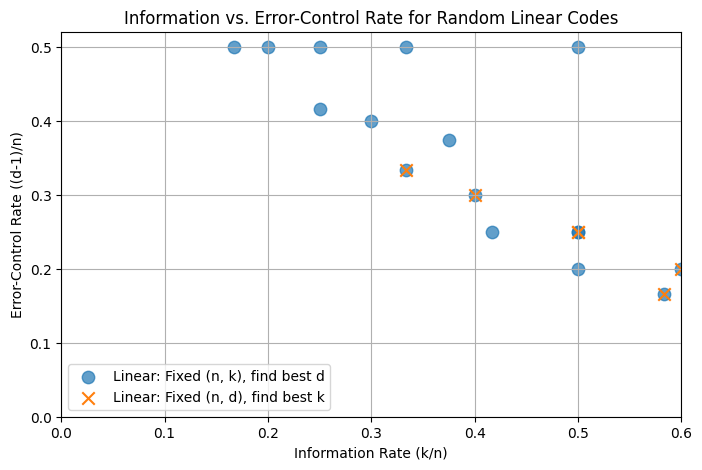

In [20]:
results_linear_k = []
results_linear_d = []
n_values = [6, 8, 10, 12] # Use slightly larger n for linear codes

print("Method A (fixed n, k -> find best d):")
for n in n_values:
    k_steps = range(2, int(n / 2) + 2)
    for k in k_steps:
        print(f"  Testing n={n}, k={k}...")
        best_code = find_best_linear_code_fixed_k(n, k, num_trials=200)
        if best_code:
            results_linear_k.append({
                "info_rate": best_code.information_rate,
                "error_rate": best_code.error_control_rate
            })

print("Method B (fixed n, d -> find best k):")
for n in n_values:
    d_steps = range(2, int(n / 2))
    for d in d_steps:
        print(f"  Testing n={n}, d={d}...")
        best_code = find_best_linear_code_fixed_d(n, d, num_trials=5)
        if best_code and best_code.k > 0:
            results_linear_d.append({
                "info_rate": best_code.information_rate,
                "error_rate": best_code.error_control_rate
            })

fig, ax = plt.subplots(figsize=(8, 5))

if results_linear_k:
    info_rates = [res['info_rate'] for res in results_linear_k]
    error_rates = [res['error_rate'] for res in results_linear_k]
    ax.scatter(info_rates, error_rates,
                alpha=0.7, s=80, label='Linear: Fixed (n, k), find best d')

if results_linear_d:
    info_rates = [res['info_rate'] for res in results_linear_d]
    error_rates = [res['error_rate'] for res in results_linear_d]
    ax.scatter(info_rates, error_rates, marker='x', s=80,
                label='Linear: Fixed (n, d), find best k')

ax.set_title('Information vs. Error-Control Rate for Random Linear Codes')
ax.set_xlabel('Information Rate (k/n)')
ax.set_ylabel('Error-Control Rate ((d-1)/n)')
ax.legend()
ax.grid(True)
plt.xlim(0, 0.6)
plt.ylim(bottom=0)
plt.show()

The plot for linear codes reveals the same trade-off observed with general random codes. The information rate and error-control rate are inversely related. It is impossible to have a code that is both extremely dense with information and extremely resilient to errors.

When comparing this plot to the one for general random codes, we often find that the boundary for linear codes is very close to the boundary for general codes. This is a known result in coding theory, random linear codes perform just as well, on average, as general random codes.

Linear codes are vastly superior in practice for several reasons. Encoding a message is a simple matter of matrix multiplication, multiplying a message vector by the generator matrix. Also, we only need to store the k generator vectors (a $k \times n$ matrix) instead of all $r = 2^k$ codewords. Finally, finding the minimum distance $d$ is significantly faster. We only need to compute the weight of $2^k - 1$ non-zero codewords instead of computing the distance between all $(2^k  (2^k - 1)) / 24$ pairs of codewords.

By restricting our search to linear codes, we lose virtually nothing in terms of performance regarding the trade-off between information rate and error control. However, we gain benefits in terms of computational efficiency, storage, and ease of implementation.


---

Several bounds in coding theory describe the limits of this trade-off.
*   The singleton bound: For any code, $r \leq 2^{n-d+1}$. In terms of rates, this means that $R \leq 1 - \delta + 1/n$, where $R$ is the information rate and $\delta = d/n$ is the relative distance. Codes that achieve this bound are called MDS (maximum distance separable) codes which are rare for binary alphabets.
*   The Hamming (sphere packing) bound: This bound states that the number of codewords $r$ is limited by the fact that spheres of radius $t$, where $t = \left\lfloor \frac{d-1}{2} \right\rfloor$ is the number of correctable errors, around each codeword cannot overlap. The bound is given by $r \sum_{i=0}^t \binom{n}{i}$. Codes that meet this bound with equality are called "perfect codes. Our random searches are unlikely to find these codes.
*   The Gilbert-Varshamov bound: The GV bound is a lower bound and it guarantees the existence of good codes. It states that a greedy algorithm for constructing a code will succeed as long as there is space left to place a new codeword. Asymptotically, typical random linear codes are known to achieve this bound.

Claude Shannon's noisy-channel coding theorem states that for any noisy communication channel, there is a maximum rate, called the channel capacity $C$, at which information can be transmitted with an arbitrarily low probability of error. A code with a minimum distance $d$ can correct up to $t$ errors. Therefore, a code with a higher error-control rate is more robust against channel noise and can achieve a lower error probability.

Our methods successfully produce codes that have good parameters and empirically validate the major theoretical bounds. A simple random selection of $k$ linear generators was able to produce a code that lies near the Gilbert-Varshamov bound. Indeed, for large $n$, most codes lie close to the GV bound

The biggest drawback of oue methods is that they produce codes with no inherent algebraic structure. A code is only useful in practice if there is an efficient algorithm to decode a received, possibly corrupted, message back to the original. For a randomly generated code, the only way to decode is via maximum likelihood decoding, which involves comparing the received word to every single codeword in the codebook. For a code of size $r=2^k$, this is computationally infeasible.

Random search is not guaranteed to find the best possible code for a given $n$ and $k$, which are often highly unique and structured. Whilst we get close to the theoretical bounds, we rarely, if ever, land on these exceptional, optimal codes. The greedy algorithm, while better than pure random search, become very slow as the code size grows.